Recurrent spillover branching process (infinite population), plots beta, gamma, and number infected over time.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#class representing one simulation.
#an instance of this class contains enough information to plot some pictures.
#the return value for sim_class and for recurrent_sim_class is an instance of this class. 

class Sim:
    def __init__(self, outcome, times, betas, gammas, N_infecteds, deltas=None, spillover_ids=None, S=None, D=None):
        
        #0 if extinction, 1 if outbreak, None otherwise. 
        #(note sim_class will always return 0 or 1 here, but recurrent_sim_class may return None)
        self.outcome = outcome 
        
        #the number of events in the simulation
        self.length = len(times) # note this is = len(self.betas) = len(self.gammas)= len(self.N)
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.N = N_infecteds #the number of infecteds, inclusive of the new event
        self.spillover_ids = spillover_ids #which spillover tree each event belongs to. the spillover trees ids are integers beginning with 0
        self.deltas = deltas
        self.S = S
        self.D = D
    
        if spillover_ids is None: #if there are no ids, assume they are all part of the same tree, so make them all 0.
            self.spillover_ids = np.zeros(self.length)

In [5]:
################################################
#
# version of recurrent_sim which returns an element of the class Sim.
#
# will run until either we get an outbreak, or the simulation times out at specified threshold time.
# there is one other option, which occurs only if alpha = 0 and the infection goes extinct.
# (when alpha > 0, we will keep running, instead of stopping, at an extinction time.)
#
################################################
#
# optional input t_thresh is the maximum number of simulated days to run.
# optional input outbreak_thresh. we call it an outbreak if this many people are infected 
#
# returns an instance of the class Sim.
# the return object will be "None" for self.outcome if the simulation timed out by hitting the threshold time. 
# otherwise if we had an outbreak, self.outcome will be 1.
# finally, if alpha=0 and we had extinction, self.outcome will be 0.
#
#################################################

def recurrent_sim_class(alpha, beta_0, gamma_0, mu_1, mu_2, t_thresh = 1000, outbreak_thresh = 100):
    
    t=0
        
    #stuff to fill and return as part of Sim object.
    times = np.array([t])
    all_betas = np.array([beta_0])
    all_gammas = np.array([gamma_0])
    all_I = np.array([1])
    spillover_ids = np.array([0]) #keep track of which spillover tree each event belongs to
    
    #keep track of how many spillover trees we have seen so far
    spillovers = 0
    
    I = 1 #initialize variable to keep track of total number of infected
        
    #initialize variables to keep track of sums of beta and gamma over all currently infected people    
    beta_sum = beta_0
    gamma_sum = gamma_0
        
    #initialize matrix of active cases. each case is a row of length 4.
    # each row looks like [beta, gamma, time of infection, spillover id] of that person. 
    infecteds=np.array([[beta_0, gamma_0, t, spillovers]])
    
    while True:
        
        #grab array of all betas and array of all gammas
        betas = infecteds[:,0]
        gammas = infecteds[:,1]
        
        #compute interevent time (for the whole population)
        #rate of events is = alpha + (sum of beta and gamma over all infected people)
        overall_rate = beta_sum + gamma_sum + alpha
        
        #if alpha = 0 and we had extinction
        if alpha == 0 and I == 0:
            #print("extinction")
            return Sim(0, times, all_betas, all_gammas, all_I)
        
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt
        
        #check if we exceeded t_thresh
        if t > t_thresh:
            #print('exceeded t_thresh')
            return Sim(None, times, all_betas, all_gammas, all_I, spillover_ids)
        
        #figure out whether the event was a new spillover
        event = np.random.rand() #draw from uniform distribution over [0, 1)
        p_spillover = alpha/overall_rate
            
        if event < p_spillover: #new spillover
            
            #update total spillovers counter
            spillovers += 1
            
            #append new case to infecteds array
            infecteds = np.append(infecteds, [[beta_0, gamma_0, t, spillovers]], axis=0)

            #update the sums of beta and gamma
            beta_sum += beta_0; gamma_sum += gamma_0

            #update I
            I += 1

            #update return arrays
            times = np.append(times, t)
            all_betas = np.append(all_betas, beta_0)
            all_gammas = np.append(all_gammas, gamma_0)
            all_I = np.append(all_I, I)
            spillover_ids = np.append(spillover_ids, spillovers)

            #check if we have an outbreak
            if I >= outbreak_thresh:
                #print("outbreak!")
                return Sim(1, times, all_betas, all_gammas, all_I, spillover_ids)

            continue #skip to next event
        
        #otherwise, the event was that somebody either transmitted or recovered
        
        #figure out which person that was
        i = np.random.choice(I, p=(betas+gammas)/(overall_rate-alpha)) #index of that person
        
        #grab their specific beta, gamma, and spillover id
        beta = betas[i]; gamma = gammas[i]
        spillover_id = infecteds[i][3]
        
        #figure out what they did, transmit or recover. 
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = beta / (beta + gamma) #probability of transmission

        if (ev < prob_trans): #transmission

            #pick beta and gamma for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
            #don't allow negative beta.
            #don't allow gamma to be less than a small value, the natural death rate.
            mut1 = np.random.normal(loc=0.0, scale=mu_1)
            new_beta = max(0, beta + mut1)
            mut2 = np.random.normal(loc=0.0, scale=mu_2)              
            nat_death = 0.00002366575 #taken from CDC: 
                #https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
            new_gamma = max(nat_death, gamma + mut2)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t, spillover_id]], axis=0)
            
            #update the sums of beta and gamma
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update I
            I += 1
            
            #update return arrays
            times = np.append(times, t)
            all_betas = np.append(all_betas, new_beta)
            all_gammas = np.append(all_gammas, new_gamma)
            all_I = np.append(all_I, I)
            spillover_ids = np.append(spillover_ids, spillover_id)

            #check if we have an outbreak
            if I >= outbreak_thresh:
                #print("\n", "outbreak!")
                return Sim(1, times, all_betas, all_gammas, all_I, spillover_ids)

        else: #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update the sums of beta and gamma
            beta_sum -= betas[i]; gamma_sum -= gammas[i]
            
            #update I
            I -= 1
            
            #update return arrays
            times = np.append(times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_I = np.append(all_I, I)
            spillover_ids = np.append(spillover_ids, spillover_id)

outcome =  1


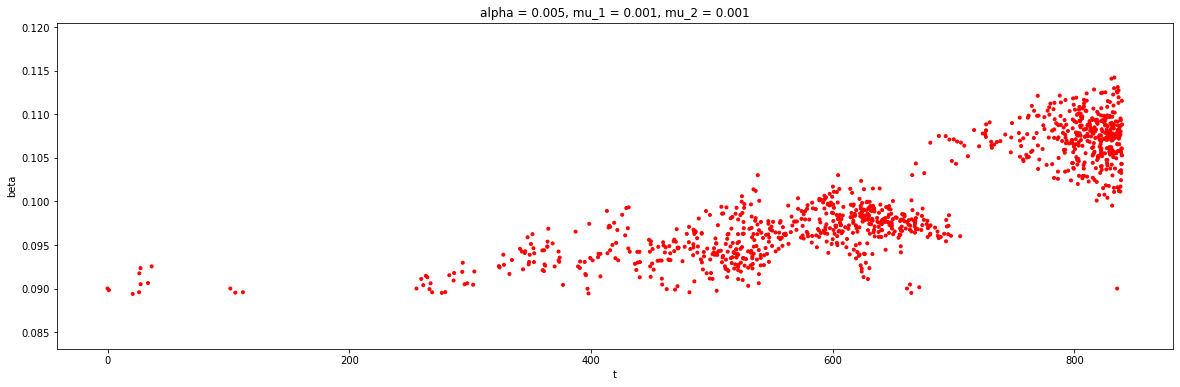

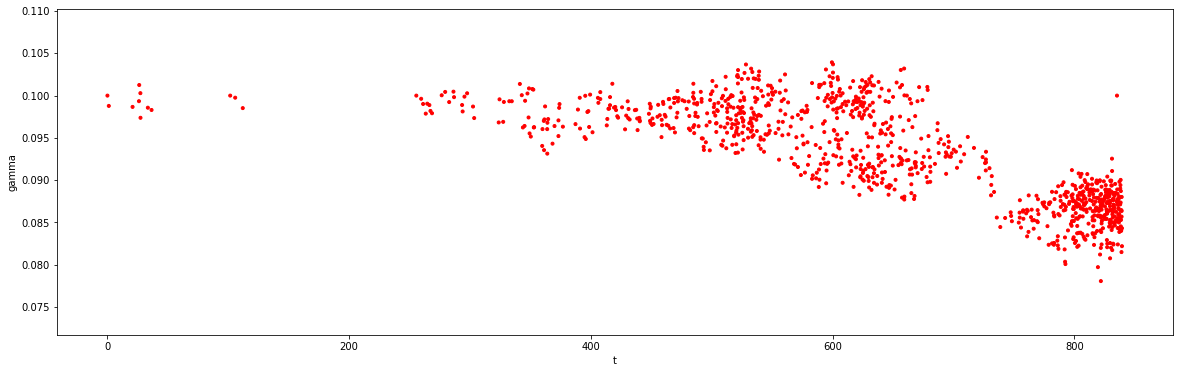

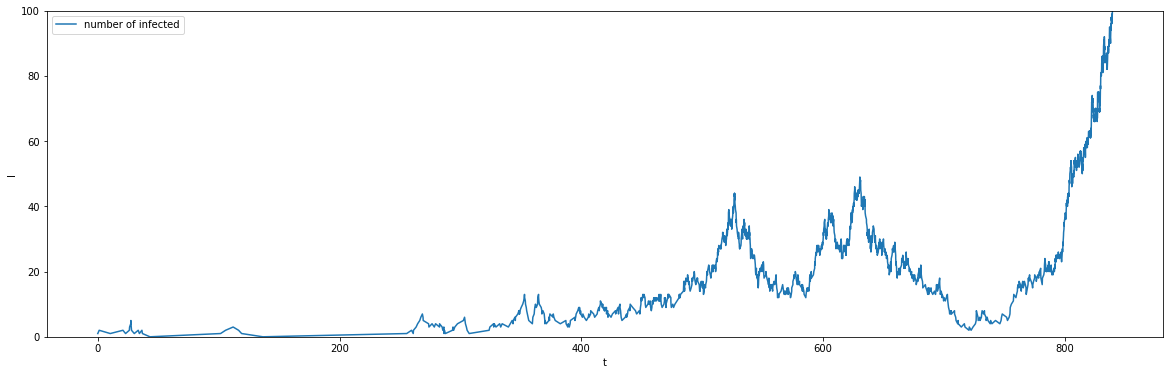

In [6]:
#color cycles for different spillover trees
def colors(ids):
    dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'purple' }
    colors = []
    for id in ids:  
        colors.append(dict[id%6])
    return colors

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.001
mu_2 = 0.001
alpha = 0.005

t_thresh = 20000
outbreak_thresh = 100

#compute the simulation

while True:
    s = recurrent_sim_class(alpha, beta_0, gamma_0, mu_1, mu_2, t_thresh=t_thresh, outbreak_thresh = outbreak_thresh)
    if s.outcome == 1: break
    
times = s.times; betas = s.betas; gammas = s.gammas; N_infecteds = s.N
spillover_ids = s.spillover_ids

print('outcome = ', s.outcome)



#plots

#plot betas and gammas over time
plt.figure(figsize=(20,6))
plt.scatter(times, betas, marker = ".", c=colors(spillover_ids), label = 'beta')
plt.title('alpha = {}, mu_1 = {}, mu_2 = {}'.format(alpha, mu_1, mu_2))
plt.xlabel("t"); plt.ylabel("beta")
plt.show()

plt.figure(figsize=(20,6))
plt.scatter(times, gammas, marker = ".", c=colors(spillover_ids), label = 'gamma')
plt.xlabel("t"); plt.ylabel("gamma")
plt.show()

#plot I over time
plt.figure(figsize=(20,6))
plt.plot(times, N_infecteds, label='number of infected')
plt.xlabel("t"); plt.ylabel("I")
plt.ylim(0, outbreak_thresh)
plt.legend(); plt.show()